# Introduction to SimpleITKv4 Registration <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F60_Registration_Introduction.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

**SimpleITK conventions:**
* Dimensionality and pixel type of registered images is required to be the same (2D/2D or 3D/3D).
* Supported pixel types are sitkFloat32 and sitkFloat64 (use the SimpleITK [Cast](http://www.simpleitk.org/doxygen/latest/html/namespaceitk_1_1simple.html#af8c9d7cc96a299a05890e9c3db911885) function if your image's pixel type is something else).

## Registration Components 

<img src="ITKv4RegistrationComponentsDiagram.svg"/><br><br>

There are many options for creating an instance of the registration framework, all of which are configured in SimpleITK via methods of the <a href="http://www.simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ImageRegistrationMethod.html">ImageRegistrationMethod</a> class. This class encapsulates many of the components available in ITK for constructing a registration instance.

Currently, the available choices from the following groups of ITK components are:

### Optimizers

The SimpleITK registration framework supports several optimizer types via the SetOptimizerAsX() methods, these include:
* [Exhaustive](http://www.itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html)
* [Nelder-Mead downhill simplex](http://www.itk.org/Doxygen/html/classitk_1_1AmoebaOptimizerv4.html), a.k.a. Amoeba
* [Powell optimizer](https://itk.org/Doxygen/html/classitk_1_1PowellOptimizerv4.html)
* [1+1 evolutionary optimizer](https://itk.org/Doxygen/html/classitk_1_1OnePlusOneEvolutionaryOptimizerv4.html)
* Variations on gradient descent:
  * [GradientDescent](http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentOptimizerv4Template.html)
  * [GradientDescentLineSearch](http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentLineSearchOptimizerv4Template.html)
  * [RegularStepGradientDescent](http://www.itk.org/Doxygen/html/classitk_1_1RegularStepGradientDescentOptimizerv4.html)
* [ConjugateGradientLineSearch](http://www.itk.org/Doxygen/html/classitk_1_1ConjugateGradientLineSearchOptimizerv4Template.html)
* [L-BFGS2](https://itk.org/Doxygen/html/classitk_1_1LBFGS2Optimizerv4.html) (Limited memory Broyden, Fletcher, Goldfarb, Shannon)
* [L-BFGS-B](http://www.itk.org/Doxygen/html/classitk_1_1LBFGSBOptimizerv4.html) (Limited memory Broyden,  Fletcher,Goldfarb,Shannon-Bound Constrained) - supports the use of simple constraints ($l\leq x \leq u$)  


 
### Similarity metrics

The SimpleITK registration framework supports several metric types via the SetMetricAsX() methods, these include:
* [MeanSquares](http://www.itk.org/Doxygen/html/classitk_1_1MeanSquaresImageToImageMetricv4.html)
* [Demons](http://www.itk.org/Doxygen/html/classitk_1_1DemonsImageToImageMetricv4.html)
* [Correlation](http://www.itk.org/Doxygen/html/classitk_1_1CorrelationImageToImageMetricv4.html)
* [ANTSNeighborhoodCorrelation](http://www.itk.org/Doxygen/html/classitk_1_1ANTSNeighborhoodCorrelationImageToImageMetricv4.html)
* [JointHistogramMutualInformation](http://www.itk.org/Doxygen/html/classitk_1_1JointHistogramMutualInformationImageToImageMetricv4.html)
* [MattesMutualInformation](http://www.itk.org/Doxygen/html/classitk_1_1MattesMutualInformationImageToImageMetricv4.html)


### Interpolators

The SimpleITK registration framework supports several interpolators via the SetInterpolator() method, which receives one of
the [following enumerations](http://www.simpleitk.org/doxygen/latest/html/namespaceitk_1_1simple.html#a7cb1ef8bd02c669c02ea2f9f5aa374e5):
* sitkNearestNeighbor 
* sitkLinear
* sitkBSpline1, sitkBSpline2, sitkBSpline3, sitkBSpline4, sitkBSpline5, where the number denotes the spline order, with sitkBSpline3 being the go-to option.
* sitkGaussian
* sitkHammingWindowedSinc
* sitkCosineWindowedSinc
* sitkWelchWindowedSinc
* sitkLanczosWindowedSinc
* sitkBlackmanWindowedSinc

## Data -  Retrospective Image Registration Evaluation

We will be using part of the training data from the Retrospective Image Registration Evaluation ([RIRE](https://rire.insight-journal.org/)) project.

In [4]:
import SimpleITK as sitk
# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

# Always write output to a separate directory, we don't want to pollute the source directory.
import os

OUTPUT_DIR = "Output"

## Utility functions
A number of utility callback functions for image display and for plotting the similarity metric during registration.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output


# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## Read images

We first read the images, casting the pixel type to that required for registration (Float32 or Float64) and look at them.

In [6]:
fixed_image = sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32)

interact(
    display_images,
    fixed_image_z=(0, fixed_image.GetSize()[2] - 1),
    moving_image_z=(0, moving_image.GetSize()[2] - 1),
    fixed_npa=fixed(sitk.GetArrayViewFromImage(fixed_image)),
    moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)),
);

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha


interactive(children=(IntSlider(value=14, description='fixed_image_z', max=28), IntSlider(value=12, descriptio…

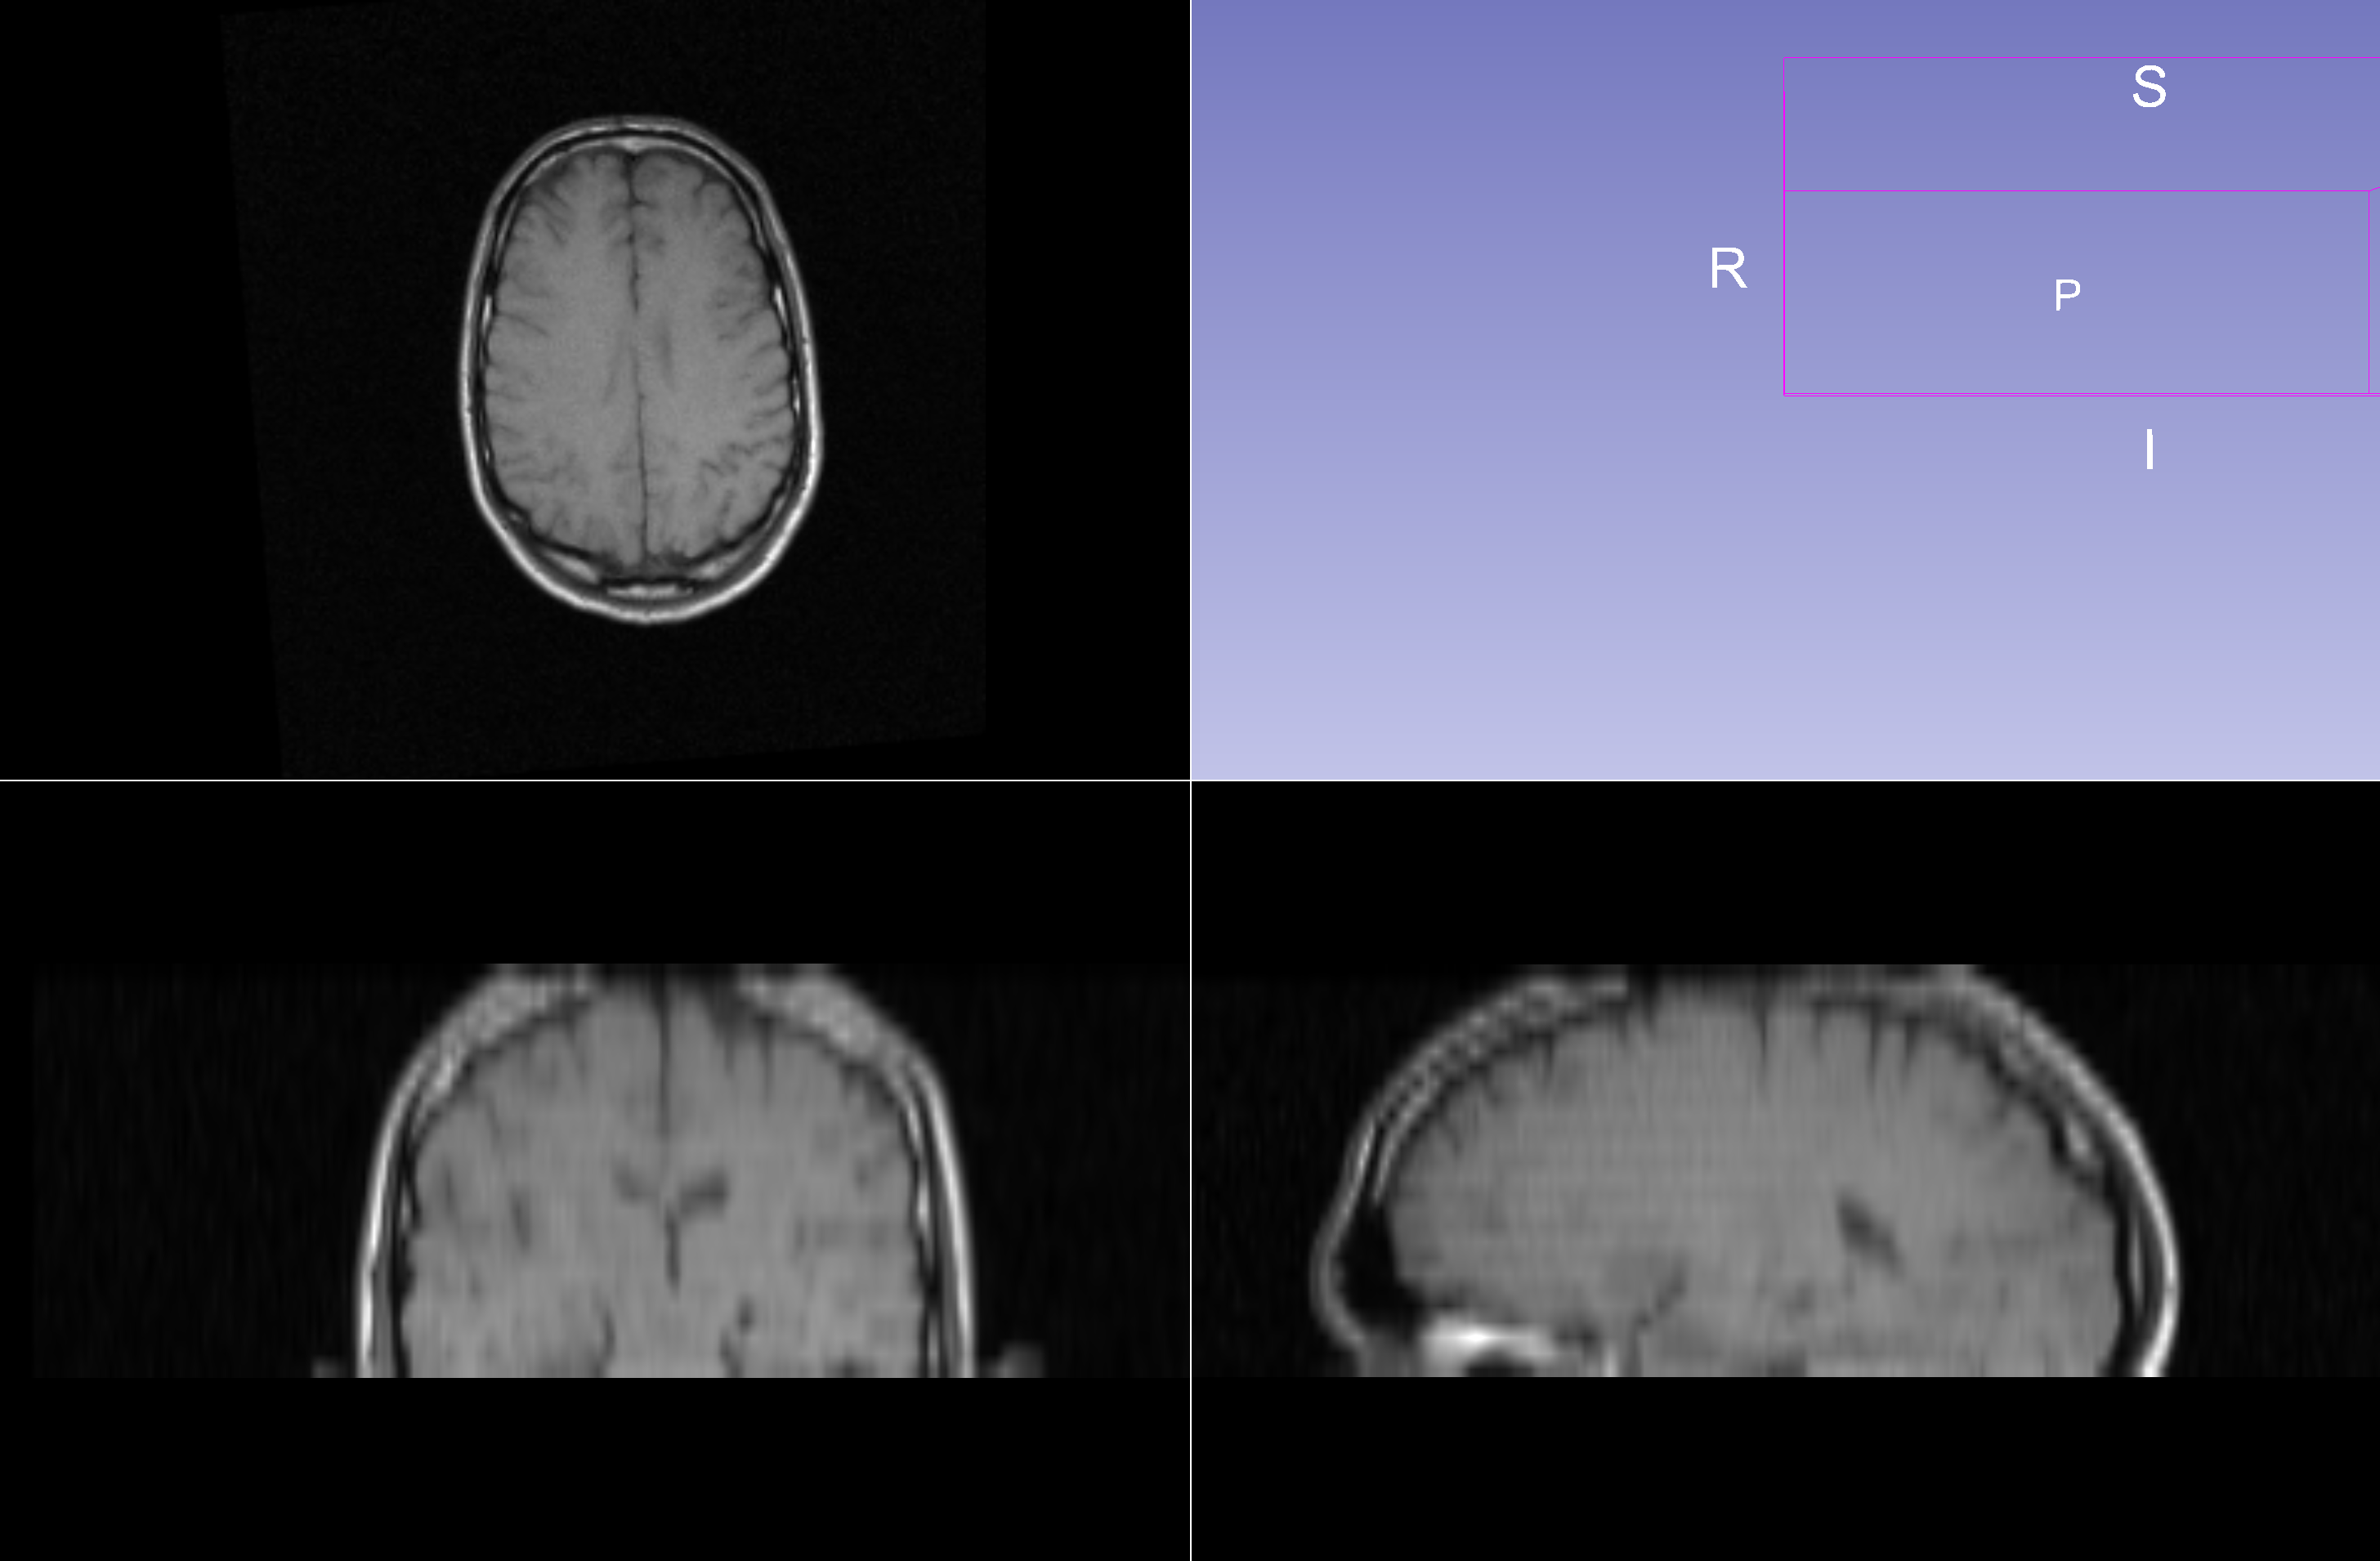

In [5]:
# this part can still be improved by 
# 1. setting the background with two scans
# 2. link slice views
# 3. 
volumeNode_fixed.GetDisplayNode().SetAutoWindowLevel(False)
volumeNode_moving.GetDisplayNode().SetAutoWindowLevel(False)
# Set up view layout
slicer.app.layoutManager().setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutFourUpView)
# Set up slice views
slicer.util.setSliceViewerLayers(foreground=volumeNode_moving, fit=False)
slicer.util.setSliceViewerLayers(background=volumeNode_fixed, fit=False)

# Show volume rendering
# slicernb.showVolumeRendering(volumeNode, presetName='MR-Default')
# slicer.util.resetThreeDViews()
# Display views
slicernb.ViewDisplay()

## Initial Alignment

Use the CenteredTransformInitializer to align the centers of the two volumes and set the center of rotation to the center of the fixed image.

In [7]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    initial_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

interactive(children=(IntSlider(value=14, description='image_z', max=28), FloatSlider(value=0.5, description='…

## Registration

The specific registration task at hand estimates a 3D rigid transformation between images of different modalities. There are multiple components from each group (optimizers, similarity metrics, interpolators) that are appropriate for the task. Note that each component selection requires setting some parameter values. We have made the following choices:

<ul>
<li>Similarity metric, mutual information (Mattes MI):
<ul>
  <li>Number of histogram bins, 50.</li>
  <li>Sampling strategy, random.</li>
  <li>Sampling percentage, 1%.</li>
</ul>
</li>
<li>Interpolator, sitkLinear.</li>
<li>Optimizer, gradient descent: 
<ul>
  <li>Learning rate, step size along traversal direction in parameter space, 1.0 .</li>
  <li>Number of iterations, maximal number of iterations, 100.</li>
  <li>Convergence minimum value, value used for convergence checking in conjunction with the energy profile of the similarity metric that is estimated in the given window size, 1e-6.</li>
  <li>Convergence window size, number of values of the similarity metric which are used to estimate the energy profile of the similarity metric, 10.</li>
</ul>
</li>
</ul>


Perform registration using the settings given above, and take advantage of the built in multi-resolution framework, use a three tier pyramid.  

In this example we plot the similarity metric's value during registration. Note that the change of scales in the multi-resolution framework is readily visible.

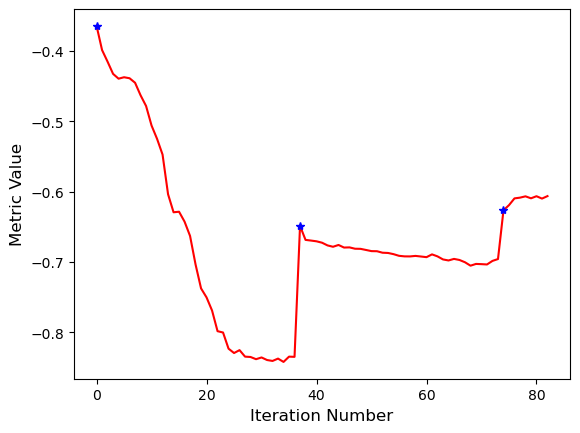

In [8]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

## Post registration analysis

Query the registration method to see the metric value and the reason the optimization terminated. 

The metric value allows us to compare multiple registration runs as there is a probabilistic aspect to our registration, we are using random sampling to estimate the similarity metric.

Always remember to query why the optimizer terminated. This will help you understand whether termination is too early, either due to thresholds being too tight, early termination due to small number of iterations - numberOfIterations, or too loose, early termination due to large value for minimal change in similarity measure - convergenceMinimumValue)

In [9]:
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)

Final metric value: -0.6102192199873523
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


Now visually inspect the results.

In [9]:
final_transform

<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x000002778F9319C0> >

In [10]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

interactive(children=(IntSlider(value=14, description='image_z', max=28), FloatSlider(value=0.5, description='…

In [12]:
sitk.Show(fixed_image)


If we are satisfied with the results, save them to file.

In [ ]:
sitk.WriteImage(
    moving_resampled, os.path.join(OUTPUT_DIR, "RIRE_training_001_mr_T1_resampled.mha")
)
sitk.WriteTransform(
    final_transform, os.path.join(OUTPUT_DIR, "RIRE_training_001_CT_2_mr_T1.tfm")
)

In the cell above we separately saved (1) a resampled version of the moving image and (2) the final registration transformation. Another option is to forgo the resampling and combine the transformation into the original moving image, "physically" moving it in space. This operation modifies the image's origin and direction cosine matrix but leaves the intensity information as is, image size and spacing don't change. In Slicer nomenclature this is referred to as "transform hardening".

In [11]:
transformed_moving = sitk.TransformGeometry(moving_image, final_transform)
print(
    f"origin before: {moving_image.GetOrigin()}\norigin after: {transformed_moving.GetOrigin()}"
)
print(
    f"direction cosine before: {moving_image.GetDirection()}\ndirection cosine after: {transformed_moving.GetDirection()}"
)
sitk.WriteImage(
    transformed_moving,
    os.path.join(OUTPUT_DIR, "RIRE_training_001_mr_T1_transformed.mha"),
)

origin before: (0.0, 0.0, 0.0)
origin after: (-8.079655600640343, 22.798575064333434, 21.819687042342217)
direction cosine before: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
direction cosine after: (0.9983740795761203, -0.05698897960727642, -0.001205584445817245, 0.05698946727750148, 0.9983747095603478, 0.00037407180840555454, 0.0011823070502823844, -0.00044216921273742085, 0.9999992033178958)
